<a href="https://colab.research.google.com/github/Code-CloudSG/Recommender/blob/main/my_CollabMovielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.collab import *
from fastai.tabular import *

## Movielens 100k

The full Movielens 100k data dataset is available at http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path=Config.data_path()/'Movielens100k'
path

PosixPath('/root/.fastai/data/Movielens100k')

In [ ]:
mkdir -p /root/.fastai/data/Movielens100k

In [ ]:
# Download the file from gs store
file = path/'ml100k.zip'
_=download_url('https://storage.googleapis.com/ml_quantyca_it/shared/Movielens100k/ml100k.zip', file, overwrite=False)
file.chmod(600)

In [ ]:
cd /root/.fastai/data/Movielens100k

/root/.fastai/data/Movielens100k


In [ ]:
ls

ml100k.zip*


In [ ]:
import zipfile
with zipfile.ZipFile('ml100k.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
len(ratings)

100000

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [ ]:
data.show_batch()

userId,title,target
406,Reservoir Dogs (1992),5.0
244,Hot Shots! Part Deux (1993),3.0
85,"African Queen, The (1951)",4.0
540,"Boot, Das (1981)",5.0
592,Dream With the Fishes (1997),5.0


In [ ]:
y_range = [0,5.5] #sigmoide, tolgo 0.5 all'inizio e aggiungo 0.5 alla fine

In [ ]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1) #n_factor specifica embedding, db da 100 quindi di solito si prende la metà circa

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


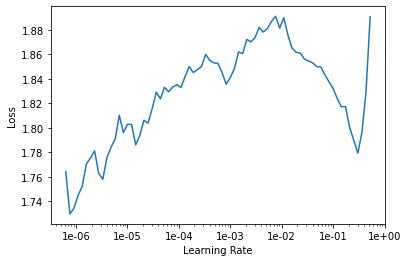

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.935029,0.939357,00:10
1,0.874893,0.877031,00:10
2,0.759858,0.835833,00:10
3,0.643792,0.811327,00:10
4,0.575315,0.811363,00:10


In [ ]:
learn.save('dotprod')

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
g.sort_values(ascending=False)[:1000]

title
Star Wars (1977)                       583
Contact (1997)                         509
Fargo (1996)                           508
Return of the Jedi (1983)              507
Liar Liar (1997)                       485
                                      ... 
Selena (1997)                           16
In the Bleak Midwinter (1995)           16
Party Girl (1995)                       16
Highlander III: The Sorcerer (1994)     16
Bastard Out of Carolina (1996)          16
Name: rating, Length: 1000, dtype: int64

In [ ]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)# true se voglio item, false se voglio users
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i], g.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
lowest_bias = sorted(movie_ratings, key=item0)[:1000]
lowest_bias

[(tensor(-0.3459),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142,
  21),
 (tensor(-0.3342),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106,
  19),
 (tensor(-0.2741),
  'Mortal Kombat: Annihilation (1997)',
  1.9534883720930232,
  43),
 (tensor(-0.2507), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053, 57),
 (tensor(-0.2480), 'Barb Wire (1996)', 1.9333333333333333, 30),
 (tensor(-0.2376), 'Home Alone 3 (1997)', 1.894736842105263, 19),
 (tensor(-0.2374), 'Bio-Dome (1996)', 1.903225806451613, 31),
 (tensor(-0.2268), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407, 27),
 (tensor(-0.2251), 'Striptease (1996)', 2.2388059701492535, 67),
 (tensor(-0.2234), 'Cable Guy, The (1996)', 2.339622641509434, 106),
 (tensor(-0.2146), 'Showgirls (1995)', 1.9565217391304348, 23),
 (tensor(-0.2123), "Joe's Apartment (1996)", 2.2444444444444445, 45),
 (tensor(-0.2119), 'Crow: City of Angels, The (1996)', 1.9487179487179487, 39),
 (tensor(-0.2083), 'Th

In [ ]:
top_bias = sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:1000]
top_bias

[(tensor(0.6440), "Schindler's List (1993)", 4.466442953020135, 298),
 (tensor(0.5740), 'Titanic (1997)', 4.2457142857142856, 350),
 (tensor(0.5723), 'Shawshank Redemption, The (1994)', 4.445229681978798, 283),
 (tensor(0.5543), 'L.A. Confidential (1997)', 4.161616161616162, 297),
 (tensor(0.5475), 'Silence of the Lambs, The (1991)', 4.28974358974359, 390),
 (tensor(0.5262), 'Star Wars (1977)', 4.3584905660377355, 583),
 (tensor(0.5240), 'As Good As It Gets (1997)', 4.196428571428571, 112),
 (tensor(0.5147), 'Rear Window (1954)', 4.3875598086124405, 209),
 (tensor(0.5137), 'Boot, Das (1981)', 4.203980099502488, 201),
 (tensor(0.4911), 'Good Will Hunting (1997)', 4.262626262626263, 198),
 (tensor(0.4665), 'Godfather, The (1972)', 4.283292978208232, 413),
 (tensor(0.4647), 'Apt Pupil (1998)', 4.1, 160),
 (tensor(0.4590), 'Usual Suspects, The (1995)', 4.385767790262173, 267),
 (tensor(0.4554),
  "One Flew Over the Cuckoo's Nest (1975)",
  4.291666666666667,
  264),
 (tensor(0.4466), 'Casa

In [ ]:
list(filter(lambda a: a[2] >=3 , lowest_bias))[:10]

[(tensor(-0.1021), 'Parent Trap, The (1961)', 3.095890410958904, 73),
 (tensor(-0.0867),
  'So I Married an Axe Murderer (1993)',
  3.0526315789473686,
  95),
 (tensor(-0.0617), 'Kalifornia (1993)', 3.2203389830508473, 59),
 (tensor(-0.0613),
  'Bridges of Madison County, The (1995)',
  3.1641791044776117,
  67),
 (tensor(-0.0488), 'Forget Paris (1995)', 3.193548387096774, 62),
 (tensor(-0.0484), 'To Die For (1995)', 3.2758620689655173, 87),
 (tensor(-0.0396), 'Barcelona (1994)', 3.018867924528302, 53),
 (tensor(-0.0393), 'Craft, The (1996)', 3.1153846153846154, 104),
 (tensor(-0.0390),
  'Cook the Thief His Wife & Her Lover, The (1989)',
  3.024390243902439,
  82),
 (tensor(-0.0386), 'Quick and the Dead, The (1995)', 3.2083333333333335, 48)]